## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import cv2
import os

## Preparar os dados

In [2]:
# Configurações gerais
R = 50  # Redimensionamento das imagens
base_path = "../data/RecFac"

In [3]:
name_list = os.listdir(base_path)
C = len(name_list)  # Número de classes
X = np.empty((R*R, 0))  # Dados p x N
Y = np.empty((C, 0))    # Rótulos one-hot C x N

for i, nome in enumerate(name_list):
    lista_imagens = os.listdir(f"{base_path}\\{nome}")
    
    # Criação do vetor one-hot
    rotulo = -np.ones((C, len(lista_imagens)))
    rotulo[i, :] = 1
    Y = np.hstack((Y, rotulo))
    
    # Processamento das imagens
    for imagem in lista_imagens:
        img = cv2.imread(f"{base_path}\\{nome}\\{imagem}", cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (R, R))
        x = img.flatten().reshape(img.size, 1)
        X = np.hstack((X, x))

# Normalização dos dados entre 0 e 1
X = (X - np.min(X)) / (np.max(X) - np.min(X))
print(f"X: {X.shape}, Y: {Y.shape}")
name_list = os.listdir(base_path)
C = len(name_list)  # Número de classes
X = np.empty((R*R, 0))  # Dados p x N
Y = np.empty((C, 0))    # Rótulos one-hot C x N

for i, nome in enumerate(name_list):
    lista_imagens = os.listdir(f"{base_path}\\{nome}")
    
    # Criação do vetor one-hot
    rotulo = -np.ones((C, len(lista_imagens)))
    rotulo[i, :] = 1
    Y = np.hstack((Y, rotulo))
    
    # Processamento das imagens
    for imagem in lista_imagens:
        img = cv2.imread(f"{base_path}\\{nome}\\{imagem}", cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (R, R))
        x = img.flatten().reshape(img.size, 1)
        X = np.hstack((X, x))

# Normalização dos dados entre 0 e 1
X = (X - np.min(X)) / (np.max(X) - np.min(X))
print(f"X: {X.shape}, Y: {Y.shape}")

X: (2500, 640), Y: (20, 640)
X: (2500, 640), Y: (20, 640)


## Funções auxiliares

In [4]:
# Função para calcular acurácia
def accuracy(y_true, y_pred):
    pred_class = np.argmax(y_pred, axis=0)
    true_class = np.argmax(y_true, axis=0)
    return np.mean(pred_class == true_class)

def confusion_matrix_labels(y_true, y_pred, num_classes=None):
    if num_classes is None:
        num_classes = int(max(y_true.max(), y_pred.max()) + 1)

    cm = np.zeros((num_classes, num_classes), dtype=float)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    with np.errstate(divide='ignore', invalid='ignore'):
        row_sums = cm.sum(axis=1, keepdims=True)
        cm = np.divide(cm, row_sums, where=row_sums != 0) * 100

    return np.nan_to_num(cm)  


def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(12, 10,))
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt='.1f',         
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Porcentagem (%)'},
        square=True
    )
    
    ax.set_xlabel('Predito', fontsize=14)
    ax.set_ylabel('Verdadeiro', fontsize=14)
    ax.set_title(title, fontsize=16, pad=20)
    
    ax.tick_params(axis='both', labelsize=12, rotation=45)
    
    plt.tight_layout(pad=2)
    plt.show()


In [5]:
def monte_carlo_split(X, Y, train_ratio=0.8):
    N = X.shape[1]
    idx = np.random.permutation(N)
    train_size = int(train_ratio * N)
    train_idx = idx[:train_size]
    test_idx = idx[train_size:]
    return X[:, train_idx], Y[:, train_idx], X[:, test_idx], Y[:, test_idx]

## Classes

In [6]:
class Perceptron:
    def __init__(self, X_train, y_train, learning_rate=1e-3, plot=True, max_epochs=1000):
        self.p, self.N = X_train.shape
        self.X_train = np.vstack((
            -np.ones((1, self.N)), X_train
        ))
        self.d = y_train
        self.lr = learning_rate
        self.w = np.random.random_sample((self.p+1,1)) - 0.5
        self.plot = plot
        self.max_epochs = max_epochs
        self.x1 = np.linspace(-2, 10)
        
        if plot:
            self.fig = plt.figure(1)
            self.ax = self.fig.add_subplot()
            self.ax.scatter(self.X_train[1, self.d[:]==1],
                            self.X_train[2, self.d[:]==1], marker='s', s=120)
            self.ax.scatter(self.X_train[1, self.d[:]==-1],
                            self.X_train[2, self.d[:]==-1], marker='o', s=120)
            self.ax.set_xlim(-1, 7)
            self.ax.set_ylim(-1, 7)
            self.draw_line()
        
    def draw_line(self, c='k', alpha=1, lw=2):
        x2 = -self.w[1,0]/self.w[2,0]*self.x1 + self.w[0,0]/self.w[2,0]
        x2 = np.nan_to_num(x2)
        if self.plot:
            plt.plot(self.x1, x2, c=c, alpha=alpha, lw=lw)
        
    def activation_function(self, u):
        return 1 if u >= 0 else -1
    
    def fit(self):
        epochs = 0
        error = True
        while error and epochs < self.max_epochs:
            error = False
            for k in range(self.N):
                x_k = self.X_train[:, k].reshape(self.p+1, 1)
                u_k = (self.w.T @ x_k)[0,0]
                y_k = self.activation_function(u_k)
                d_k = self.d[k]
                e_k = d_k - y_k
                if e_k != 0:
                    error = True
                self.w = self.w + self.lr * e_k * x_k
            
            if self.plot:
                plt.pause(.4)
                self.draw_line(c='r', alpha=.5)
            epochs += 1
        
        if self.plot:
            plt.pause(.4)
            self.draw_line(c='g', alpha=1, lw=4)
            plt.show()
            
        if epochs == self.max_epochs:
            misclassified = [k for k in range(self.N) 
            if self.activation_function((self.w.T @ self.X_train[:, k].reshape(self.p+1,1))[0,0]) != self.d[k]]
            print(f'Treinamento interrompido após {epochs} épocas (não convergiu completamente).')
            print("Índices dos exemplos incorretos:", misclassified)
            print("Pesos finais:", self.w.ravel())

    def predict(self, X):
        N = X.shape[1]
        y_pred = np.zeros(N)
        for i in range(N):
            x_i = np.vstack((-np.ones((1,1)), X[:,i].reshape(-1,1)))
            y_pred[i] = self.activation_function((self.w.T @ x_i)[0,0])
        return y_pred

In [7]:
class MultilayerPerceptron:
    def __init__(self,X_train:np.ndarray, Y_train:np.ndarray, topology:list, learning_rate = 1e-3, max_epoch=10000, tol = 1e-12):
        '''
        X_train (p x N)
        Y_train (C x N) ou (1 x N) se classificação binária
        '''
        self.p , self.N = X_train.shape
        self.m = Y_train.shape[0]
        
        self.X_train = np.vstack((
            -np.ones((1,self.N)),X_train
        ))
        self.tol = tol
        self.lr = learning_rate
        self.d = Y_train
        topology.append(self.m)
        self.W = [None]*len(topology)
        Z = 0
        for i in range(len(self.W)):
            if i == 0:
                W = np.random.random_sample((topology[i],self.p+1))-.5
            else:
                W = np.random.random_sample((topology[i],topology[i-1]+1))-.5
            self.W[i] = W
            Z += W.size
        print(f"Rede MLP com {Z} parâmetros")
        self.max_epoch = max_epoch
        self.y = [None]*len(topology)
        self.u = [None]*len(topology)
        self.delta = [None]*len(topology)
        
    def g(self, u):
        return (1-np.exp(-u))/(1+np.exp(-u))
    
    def g_d(self, u):
        y = self.g(u)
        return .5*(1-y**2)
    
    def backward(self, e,x):
        for i in range(len(self.W)-1,-1,-1):
            if i == len(self.W)-1:
                self.delta[i] = self.g_d(self.u[i]) * e
                yb = np.vstack((
                    -np.ones((1,1)),
                    self.y[i-1]
                ))
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@yb.T)
            elif i == 0:
                Wnbt = (self.W[i+1][:,1:]).T
                self.delta[i] = self.g_d(self.u[i]) * (Wnbt@self.delta[i+1])
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@x.T)
                
            else:
                Wnbt = (self.W[i+1][:,1:]).T
                self.delta[i] = self.g_d(self.u[i]) * (Wnbt@self.delta[i+1])
                yb = np.vstack((
                    -np.ones((1,1)),
                    self.y[i-1]
                ))
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@yb.T)
            
    
    def forward(self, x):
        
        for i,W in enumerate(self.W):
            if i == 0:
                self.u[i] = W@x
            else:
                yb = np.vstack((
                    -np.ones((1,1)), self.y[i-1]
                ))
                self.u[i] = W@yb                
            self.y[i] = self.g(self.u[i])
         
        
        
    def EQM(self):
        s = 0
        for k in range(self.N):
            x_k = self.X_train[:,k].reshape(self.p+1,1)
            self.forward(x_k)
            y = self.y[-1]
            d = self.d[:,k].reshape(self.m,1)
            e = d - y
            s += np.sum(e**2)
        return s/(2*self.N)
        
    def fit(self):
        epoch = 0
        EQM1 = 1
        self.history = []
        
        while epoch < self.max_epoch and EQM1>self.tol:
            t1 = time()
            for k in range(self.N):
                x_k = self.X_train[:,k].reshape(self.p+1,1)
                #Forward
                self.forward(x_k)
                y = self.y[-1]
                d = self.d[:,k].reshape(self.m,1)
                e = d - y
                #Backward
                self.backward(e,x_k)
            t2 = time()
            EQM1 = self.EQM()
            self.history.append(EQM1)
            epoch+=1
            # print(f"Tempo: {t2-t1:.5f}s  Época: {epoch}, EQM: {EQM1:.15f}")

    def predict(self, X):
        """
        Faz a predição para novos dados X (p x N_test)
        Retorna uma matriz de saída (m x N_test)
        """
        N_test = X.shape[1]

        X_bias = np.vstack((-np.ones((1, N_test)), X))
        
        Y_pred = np.zeros((self.m, N_test))
        
        for k in range(N_test):
            x_k = X_bias[:, k].reshape(self.p+1, 1)
            self.forward(x_k)
            Y_pred[:, k] = self.y[-1][:, 0]
        
        return Y_pred


## Treinamentos

### Treinamento do Perceptron Simples

In [10]:
# Lista para armazenar resultados
R_simulations = 500
acc_perceptron = []
best_data = None
worst_data = None
best_acc = -np.inf
worst_acc = np.inf

for r in range(R_simulations):
    X_train, Y_train, X_test, Y_test = monte_carlo_split(X, Y)
    
    results_class = []
    perceptrons = []
    
    for c in range(Y.shape[0]):
        perc = Perceptron(X_train, Y_train[c, :], learning_rate=0.001, plot=False)
        perc.fit()
        
        y_pred = np.array([
            perc.activation_function((perc.w.T @ np.vstack((-1, X_test[:, k].reshape(-1,1))))[0,0])
            for k in range(X_test.shape[1])
        ])
        
        y_pred_bin = np.where(y_pred == 1, 1, -1)
        results_class.append(y_pred_bin.reshape(1, -1))
        perceptrons.append(perc)
    
    y_pred_all = np.vstack(results_class)
    acc = accuracy(Y_test, y_pred_all)
    
    acc_perceptron.append(acc)

    if acc > best_acc:
        best_acc = acc
        best_data = (X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy(), perceptrons.copy())
    if acc < worst_acc:
        worst_acc = acc
        worst_data = (X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy(), perceptrons.copy())


print("Acurácia média Perceptron:", np.mean(acc_perceptron))


Acurácia média Perceptron: 0.80990625


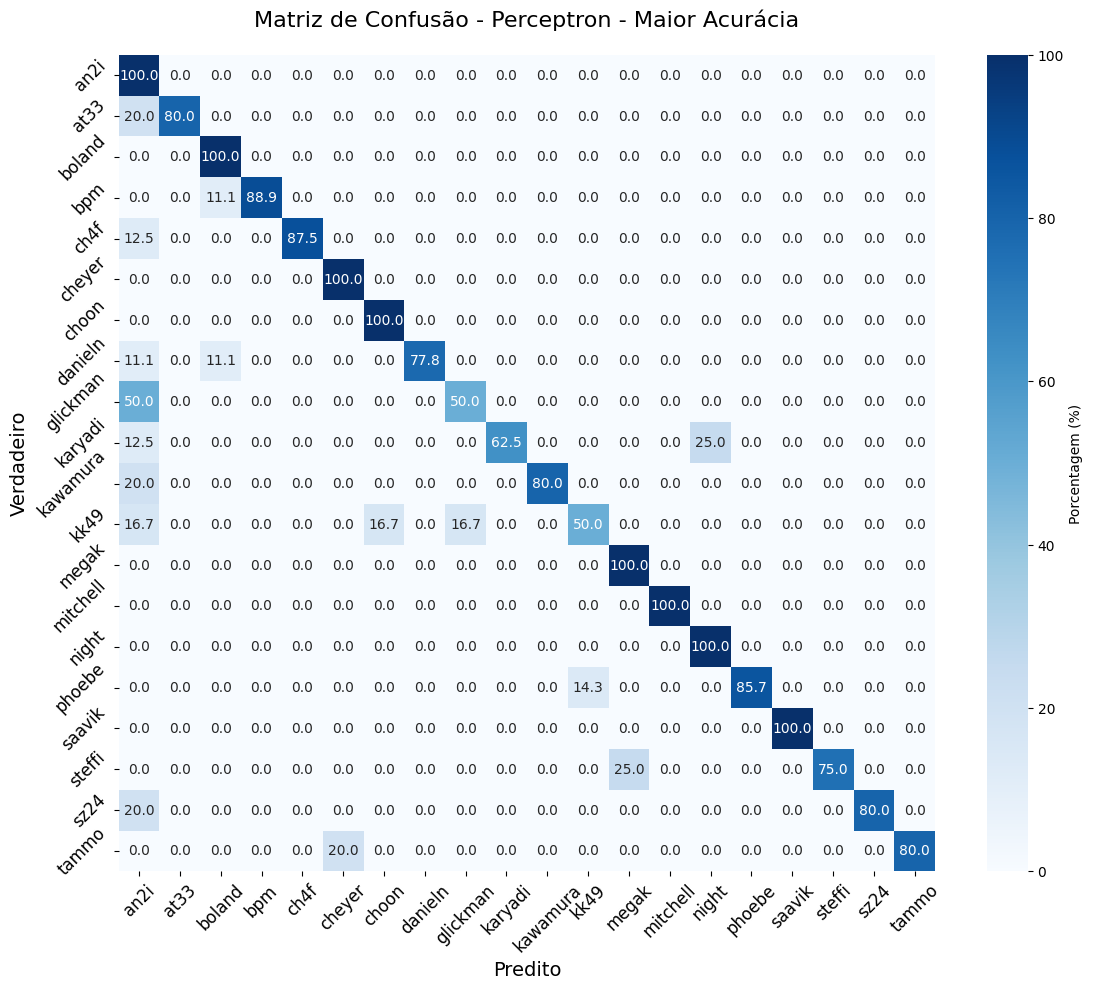

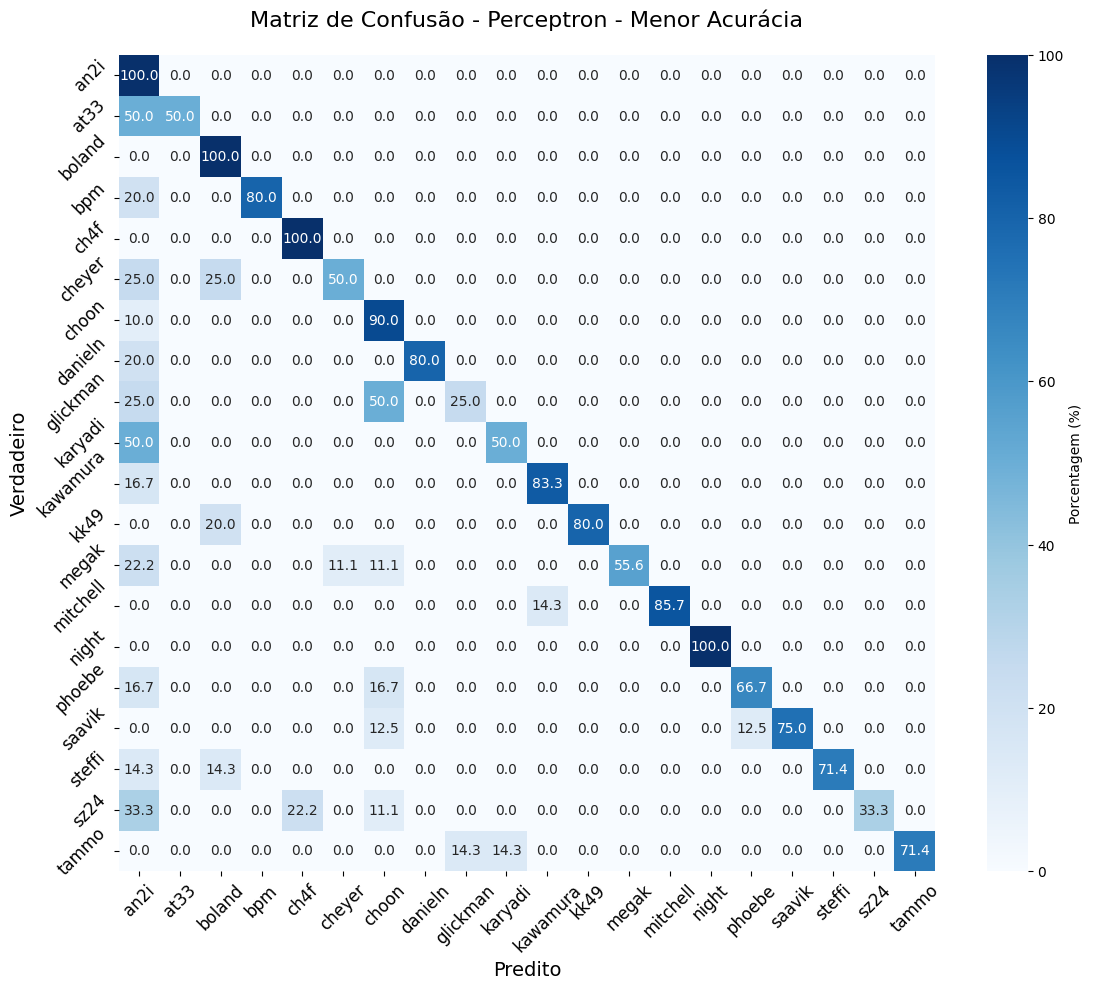

In [ ]:
# Recuperar conjuntos e perceptrons do melhor e pior caso
X_train_max, Y_train_max, X_test_max, Y_test_max, perceptrons_max = best_data
X_train_min, Y_train_min, X_test_min, Y_test_min, perceptrons_min = worst_data

# Predições para o melhor caso
Y_pred_max = []
for perc in perceptrons_max:
    y_pred = np.array([
        perc.activation_function((perc.w.T @ np.vstack((-1, X_test_max[:, k].reshape(-1,1))))[0,0])
        for k in range(X_test_max.shape[1])
    ])
    Y_pred_max.append(y_pred.reshape(1, -1))
Y_pred_max = np.vstack(Y_pred_max)

# Predições para o pior caso
Y_pred_min = []
for perc in perceptrons_min:
    y_pred = np.array([
        perc.activation_function((perc.w.T @ np.vstack((-1, X_test_min[:, k].reshape(-1,1))))[0,0])
        for k in range(X_test_min.shape[1])
    ])
    Y_pred_min.append(y_pred.reshape(1, -1))
Y_pred_min = np.vstack(Y_pred_min)

# Binário ou multiclasse
if Y_test_max.shape[0] == 1:
    Y_true_max = (Y_test_max.flatten() > 0).astype(int)
    Y_hat_max = (Y_pred_max.flatten() > 0).astype(int)
    Y_true_min = (Y_test_min.flatten() > 0).astype(int)
    Y_hat_min = (Y_pred_min.flatten() > 0).astype(int)
else:
    Y_true_max = np.argmax(Y_test_max, axis=0)
    Y_hat_max = np.argmax(Y_pred_max, axis=0)
    Y_true_min = np.argmax(Y_test_min, axis=0)
    Y_hat_min = np.argmax(Y_pred_min, axis=0)

# Matrizes de confusão
cm_max = confusion_matrix_labels(Y_true_max, Y_hat_max)
cm_min = confusion_matrix_labels(Y_true_min, Y_hat_min)

plot_confusion_matrix(cm_max, name_list, 'Matriz de Confusão - Perceptron - Maior Acurácia')
plot_confusion_matrix(cm_min, name_list, 'Matriz de Confusão - Perceptron - Menor Acurácia')


### Madaline

In [ ]:
# ===== ADALINE multi‑saída =====
def train_multioutput_adaline(X_tr, Y_tr, lr, max_epochs, print_every=50):
    p, N = X_tr.shape
    C = Y_tr.shape[0]
    Xb = np.vstack((-np.ones((1, N), dtype=np.float32), X_tr))  # viés -1
    W  = (np.random.random_sample((p+1, C)).astype(np.float32) - 0.5)
    hist_eqm = []

    def eqm():
        U = W.T @ Xb
        E = Y_tr - U
        return np.sum(E*E) / (2.0 * N)

    for ep in range(1, max_epochs+1):
        # erro e histórico (antes do update, para visualizar tendência)
        curr = eqm()
        hist_eqm.append(curr)
        if ep % print_every == 0:
            print(f'Época {ep:3d} | EQM={curr:.6f}')

        for k in range(N):
            x = Xb[:, [k]]              # (p+1,1)
            u = (W.T @ x)               # (C,1)
            d = Y_tr[:, [k]]            # (C,1)
            e = d - u                   # (C,1)
            W = W + lr * (x @ e.T)      # (p+1, C)

    return W, hist_eqm


In [ ]:
# ===== Simulação Monte Carlo - ADALINE multi-saída =====

R_simulations = 500
acc_adaline = []
histories = []
splits = []

for r in range(R_simulations):
    X_train, Y_train, X_test, Y_test = monte_carlo_split(X, Y)
    
    # Treinamento
    W, hist_eqm = train_multioutput_adaline(
        X_tr=X_train,
        Y_tr=Y_train,
        lr=0.001,
        max_epochs=750,
        print_every=250
    )

    # Predição
    Xb_test = np.vstack((-np.ones((1, X_test.shape[1]), dtype=np.float32), X_test))
    Y_pred = W.T @ Xb_test

    acc = accuracy(Y_test, Y_pred)

    acc_adaline.append(acc)
    histories.append(hist_eqm)
    splits.append((X_train, Y_train, X_test, Y_test, W))

    print(f"Simulação {r+1}/{R_simulations} concluída. Acurácia: {acc:.4f}")

print("Acurácia média ADALINE:", np.mean(acc_adaline))


Época  50 | EQM=2.004004
Época 100 | EQM=1.108222
Época 150 | EQM=0.751540
Época 200 | EQM=0.562771
Época 250 | EQM=0.448666
Época 300 | EQM=0.373659
Simulação 1/2 concluída. Acurácia: 0.8594
Época  50 | EQM=2.397260
Época 100 | EQM=1.285151
Época 150 | EQM=0.870783
Época 200 | EQM=0.658856
Época 250 | EQM=0.530208
Época 300 | EQM=0.443248
Simulação 2/2 concluída. Acurácia: 0.7812
Acurácia média ADALINE: 0.8203125


Maior acurácia ADALINE: 0.8594 na simulação 1
Menor acurácia ADALINE: 0.7812 na simulação 2


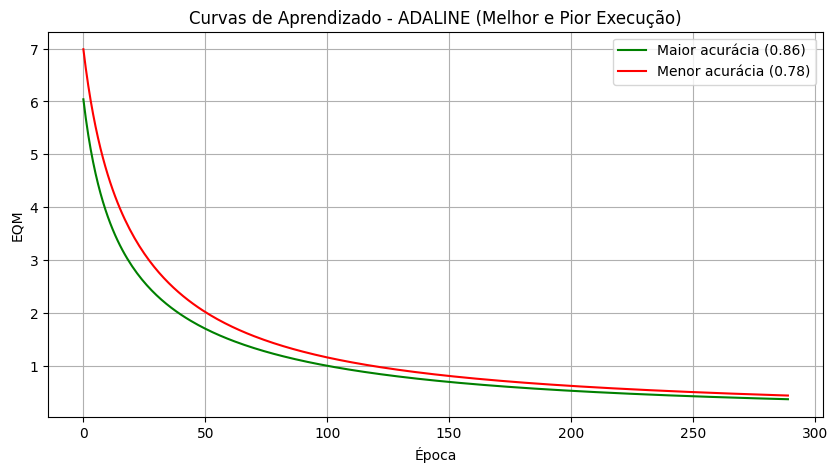

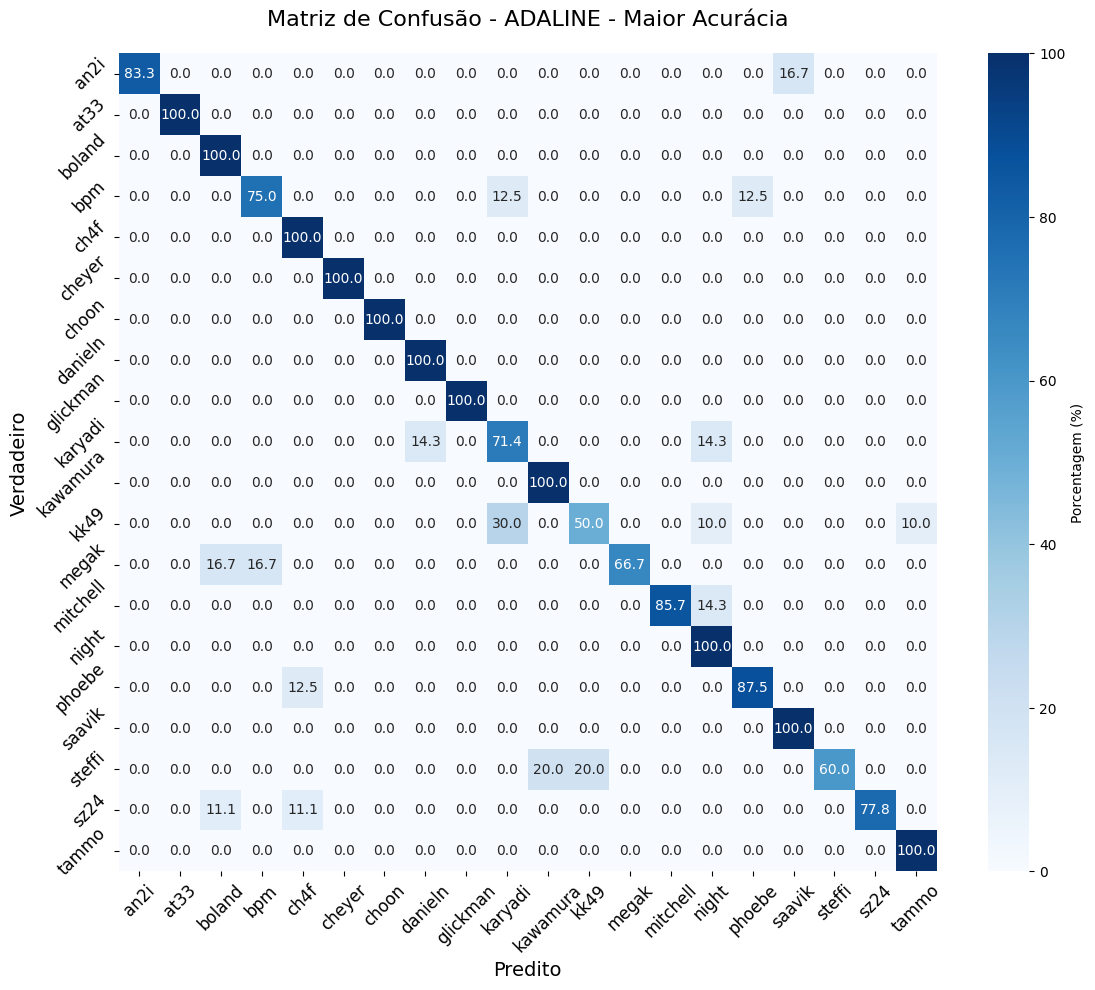

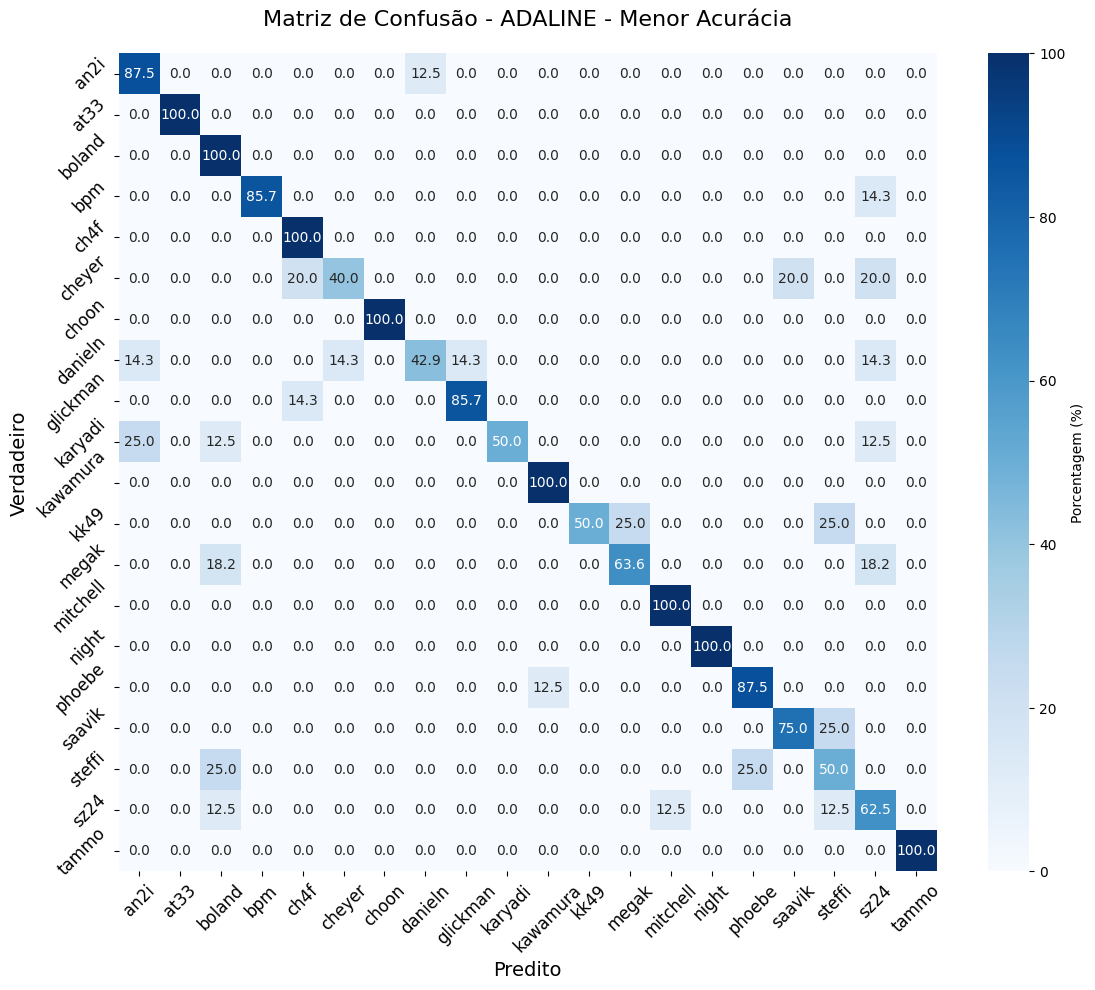

In [ ]:

# ===== Identificar o índice com maior e menor acurácia =====
idx_max = np.argmax(acc_adaline)
idx_min = np.argmin(acc_adaline)

print(f"Maior acurácia ADALINE: {acc_adaline[idx_max]:.4f} na simulação {idx_max+1}")
print(f"Menor acurácia ADALINE: {acc_adaline[idx_min]:.4f} na simulação {idx_min+1}")

# ===== Plotar as curvas de aprendizado (EQM) =====
plt.figure(figsize=(10, 5))

plt.plot(histories[idx_max][10:], label=f"Maior acurácia ({acc_adaline[idx_max]:.2f})", color='green')
plt.plot(histories[idx_min][10:], label=f"Menor acurácia ({acc_adaline[idx_min]:.2f})", color='red')

plt.xlabel("Época")
plt.ylabel("EQM")
plt.title("Curvas de Aprendizado - ADALINE (Melhor e Pior Execução)")
plt.legend()
plt.grid(True)
plt.show()

# ===== Avaliação: Matrizes de Confusão =====
# Recupera dados e pesos correspondentes
_, _, X_test_max, Y_test_max, W_max = splits[idx_max]
_, _, X_test_min, Y_test_min, W_min = splits[idx_min]

# Predições
Xb_max = np.vstack((-np.ones((1, X_test_max.shape[1])), X_test_max))
Y_pred_max = W_max.T @ Xb_max

Xb_min = np.vstack((-np.ones((1, X_test_min.shape[1])), X_test_min))
Y_pred_min = W_min.T @ Xb_min

# Tratamento para classificação binária ou multiclasse
if Y_test_max.shape[0] == 1:
    # Binária
    Y_true_max = (Y_test_max.flatten() > 0.5).astype(int)
    Y_hat_max = (Y_pred_max.flatten() > 0).astype(int)

    Y_true_min = (Y_test_min.flatten() > 0.5).astype(int)
    Y_hat_min = (Y_pred_min.flatten() > 0).astype(int)
else:
    # Multiclasse
    Y_true_max = np.argmax(Y_test_max, axis=0)
    Y_hat_max = np.argmax(Y_pred_max, axis=0)

    Y_true_min = np.argmax(Y_test_min, axis=0)
    Y_hat_min = np.argmax(Y_pred_min, axis=0)

# Matrizes de confusão
cm_max = confusion_matrix_labels(Y_true_max, Y_hat_max)
cm_min = confusion_matrix_labels(Y_true_min, Y_hat_min)

# Plot
plot_confusion_matrix(cm_max, name_list, 'Matriz de Confusão - ADALINE - Maior Acurácia')
plot_confusion_matrix(cm_min, name_list, 'Matriz de Confusão - ADALINE - Menor Acurácia')


### Treinamento do MLP

In [ ]:
acc_mlp = []
histories = []
splits = []

for r in range(R_simulations):
    X_train, Y_train, X_test, Y_test = monte_carlo_split(X, Y)
    
    # Topologia: 1 camada oculta com 50 neurônios
    mlp = MultilayerPerceptron(X_train, Y_train, topology=[50], learning_rate=0.001, max_epoch=200)
    mlp.fit()
    
    # Previsão
    Y_pred = mlp.predict(X_test)
    acc = accuracy(Y_test, Y_pred)
    
    acc_mlp.append(acc)
    histories.append(mlp.history)
    splits.append((X_train, Y_train, X_test, Y_test, mlp))

print("Acurácia média MLP:", np.mean(acc_mlp))

Rede MLP com 126070 parâmetros


KeyboardInterrupt: 

Maior acurácia MLP: 0.9844 na simulação 3
Menor acurácia MLP: 0.9531 na simulação 1


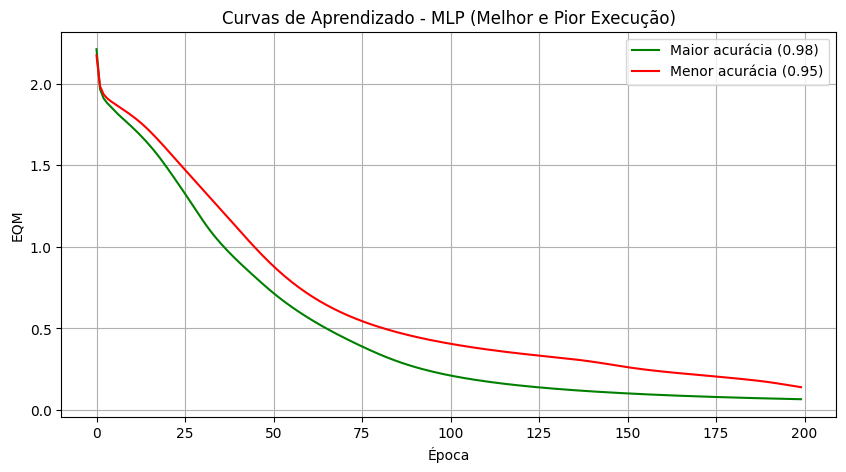

In [ ]:
# Identificar o índice com maior e menor acurácia
idx_max = np.argmax(acc_mlp)
idx_min = np.argmin(acc_mlp)

print(f"Maior acurácia MLP: {acc_mlp[idx_max]:.4f} na simulação {idx_max+1}")
print(f"Menor acurácia MLP: {acc_mlp[idx_min]:.4f} na simulação {idx_min+1}")

# Plotar as curvas de aprendizado
plt.figure(figsize=(10, 5))

plt.plot(histories[idx_max], label=f"Maior acurácia ({acc_mlp[idx_max]:.2f})", color='green')
plt.plot(histories[idx_min], label=f"Menor acurácia ({acc_mlp[idx_min]:.2f})", color='red')

plt.xlabel("Época")
plt.ylabel("EQM")
plt.title("Curvas de Aprendizado - MLP (Melhor e Pior Execução)")
plt.legend()
plt.grid(True)
plt.show()

## Resultados

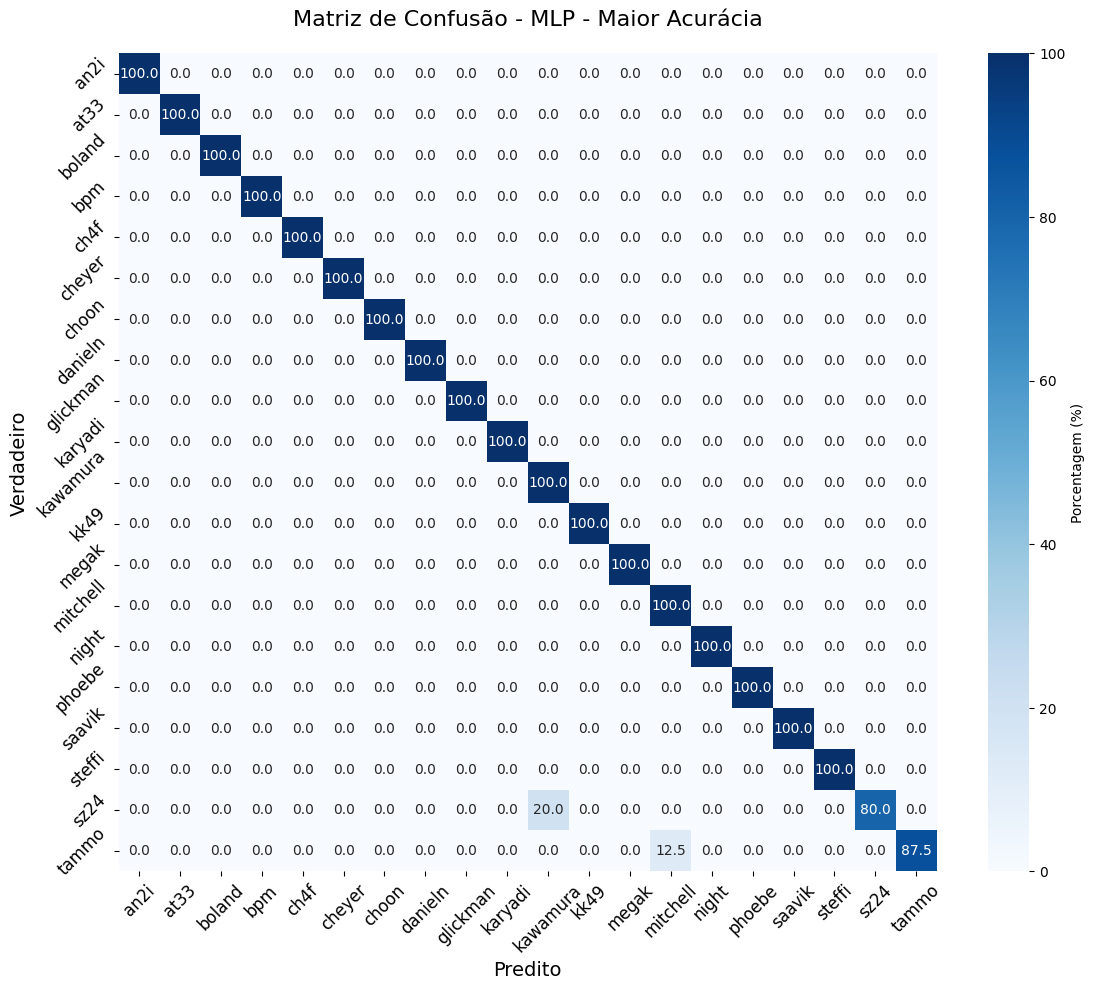

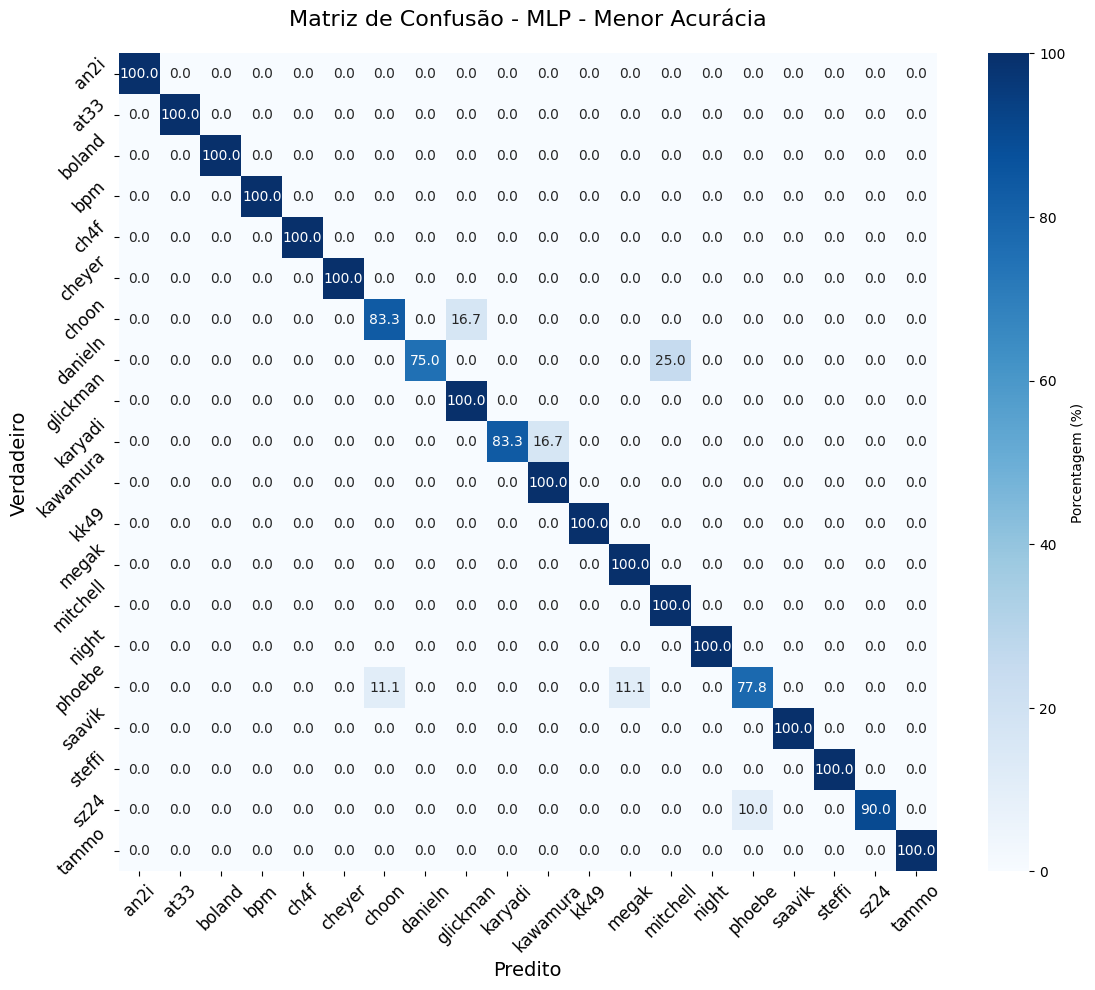

In [ ]:

# Índices de maior e menor acurácia
idx_max = int(np.argmax(acc_mlp))
idx_min = int(np.argmin(acc_mlp))

# Recupera dados e modelo correspondentes
_, _, X_test_max, Y_test_max, mlp_max = splits[idx_max]
_, _, X_test_min, Y_test_min, mlp_min = splits[idx_min]

# Predições
Y_pred_max = mlp_max.predict(X_test_max)
Y_pred_min = mlp_min.predict(X_test_min)

# Tratamento para classificação binária OU multiclasse
if Y_test_max.ndim == 1 or Y_test_max.shape[0] == 1:
    # Binária
    Y_true_max = (Y_test_max.flatten() > 0.5).astype(int)
    Y_hat_max = (Y_pred_max.flatten() > 0).astype(int)

    Y_true_min = (Y_test_min.flatten() > 0.5).astype(int)
    Y_hat_min = (Y_pred_min.flatten() > 0).astype(int)
else:
    # Multiclasse
    Y_true_max = np.argmax(Y_test_max, axis=0)
    Y_hat_max = np.argmax(Y_pred_max, axis=0)

    Y_true_min = np.argmax(Y_test_min, axis=0)
    Y_hat_min = np.argmax(Y_pred_min, axis=0)

# Matrizes de confusão
cm_max = confusion_matrix_labels(Y_true_max, Y_hat_max)
cm_min = confusion_matrix_labels(Y_true_min, Y_hat_min)


plot_confusion_matrix(cm_max, name_list, 'Matriz de Confusão - MLP - Maior Acurácia')
plot_confusion_matrix(cm_min, name_list, 'Matriz de Confusão - MLP - Menor Acurácia')

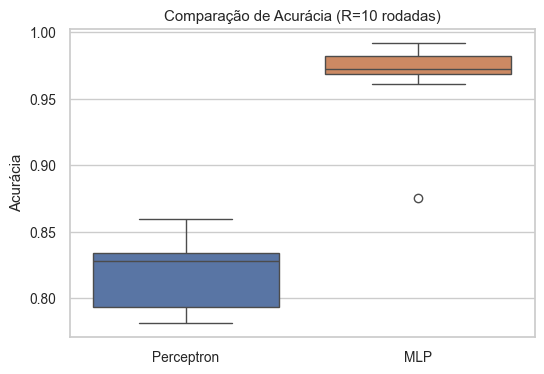

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=[acc_perceptron, acc_mlp])
plt.xticks([0,1], ['Perceptron', 'MLP'])
plt.ylabel("Acurácia")
plt.title("Comparação de Acurácia (R=10 rodadas)")
plt.show()
